# Поиск HTTP запросов

# Импорт библиотек

In [1]:
%config IPCompleter.greedy=True  # автозаполнение для удобства написания кода

Общие потребности

In [2]:
import pandas as pd
import numpy as np

Для обработки текста

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
from sklearn.decomposition import PCA

Для кластеризации (разделения запросов на группы для исследования признаков и доразметки)

In [5]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

Для рисования графиков

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

Для классификации запросов (ML)

In [7]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

Для классификации запросов (нейронные сети)

In [8]:
import keras
from tensorflow.random import set_seed

Для оценки качества работы алгоритма

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Для сохранения модели

In [10]:
import joblib

Для воспроизводимости

In [11]:
np.random.seed(0)
set_seed(0)

# Исследование данных

## Взгляд сверху

### Общий вид

Посмоторим, как выглядят первые 10 строк. По входной информации, это описание HTTP-запросов, среди которых есть вредоносные и опасные. Столбца "разметка" или подобного, описывающего классы, на первый взгляд, нет.

# Загрузка данных

In [12]:
df = pd.read_csv('data/part_10.csv', encoding='utf8')

In [13]:
df.head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp
5,79.183.87.247,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,682,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,nFzwHGQB5cBXmMW1y_TD
6,88.198.201.245,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1031,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.rid,3585221644,9KP-ImQB5cBXmMW1yeXY
7,77.72.142.170,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,763,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,214296569,97JpJGQB5cBXmMW1WqBh
8,94.50.192.153,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,3786,404,REQUEST_METHOD\';\'REQUEST_CONTE,NaN,POST\';\'multipart/form-data; boundary=----Web...,irs7_mMBjksgoq1eoQ7a
9,83.246.141.54,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,840,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,51660445,g4RdIGQB5cBXmMW10nGg


Общая характеристика данных. Видно, что некоторые столбцы почти полностью состоят из уникальных значений. Возможно, позже можно будет выделить из них информативную часть.

In [14]:
df.describe()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
count,57838,57517,57794,57770,57730,53167,57683,57666
unique,24940,6992,5758,60,21,3209,57611,54410
top,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,259,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height...",cr1nJWQB5cBXmMW1hh_4
freq,11286,2117,261,25771,20812,11165,28,7


### Код ответа: странные значения и обнаружение названий классов атак

Код ответа описан в стандартах, и может пригодиться в дальнейшем. Посмотрим распределение.

Видно, что, кроме частовстречающихся допустимых трёхзначных кодов есть ещё коды, похожие на хеш - длина у всех одинаковая, содержание как будто случайное.

Также заметно, что много кодов, начинающихся не с "2" - предполагаю, это не нормальная ситуация.

In [15]:
df.RESPONSE_CODE.value_counts()

200                                 25771
404                                 20367
302                                  6630
403                                  1156
304                                   940
504                                   700
301                                   584
502                                   558
500                                   318
400                                   212
204                                   116
206                                    90
307                                    74
405                                    63
503                                    62
401                                    46
303                                    37
207                                     4
8db0d594d4b89f35dbedc593c724c29b        1
dcbfc5eef493e919119fd48eb4f957ad        1
fc59a2c72afacddb8f8492c3c065b0e0        1
d64bdad286ae021642535d4f119a0546        1
01bfebabb27b66e033b76a34951b41cb        1
b09268bd2d762c0a2b222c2575c658ba  

Посмотрим, что за странные записи с хешами вместо кодов ответов.

Их оказалось не так уж и много. И интересная особенность - в поле "CLIENT_USERAGENT" таких записей указан класс уязвимости - "SQL Injection" или "Cross-Site Scripting". Другая особенность (возможно, чем-то позже будет объяснена) - в поле "REQUEST_SIZE" у всех них код имеет формат AVd.*Ppo9zF

И ещё одна особенность - визуально похоже, что это "сдвинутая" предыдущая строка. Как будто что-то было записно в предыдущую колонку в формате генерирующего записи средства, а при записи в CSV оказалось дублирование разделяющих символов.

In [16]:
df[df.RESPONSE_CODE.str.contains('^.{4,}$', regex=True, na=False)].shape

(40, 8)

In [17]:
df[df.RESPONSE_CODE.str.contains('^.{4,}$', regex=True, na=False)].head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
4185,\n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...,SQL Injection,AVdfPawjq1Ppo9zF4R4n,5cae7339ed82e2077c9a5da7c92c698a,NaN,NaN,NaN,NaN
10085,)vÕêx¥Å>W!¡´´üS©ó²l3¸©qKÙNâ± )ø§⟊»)qRâ...,SQL Injection,AVdXVhQZq1Ppo9zFzqqW,deea16e940c6e2818a7efe1d1ad201f0,NaN,NaN,NaN,NaN
10962,«e;½@õÍs ßëþ5â±]ÜÀ,SQL Injection,AVdpg3z4q1Ppo9zF9i1G,74d646cee1d7d983cf7a6cef6a644040,NaN,NaN,NaN,NaN
12146,I·`)ó>ïï #��é=AþyÒzþü ëVEݴG>E¼É!õý¿=Àûg...,Cross-Site Scripting,AVdXQUGaq1Ppo9zFznch,1f71588787ee4ee0ef301328471e64e9,NaN,NaN,NaN,NaN
12800,r÷ÑÎÛN7 ÏÓÇéZ(ó)Eý¥c6uóƍóm°#p,SQL Injection,AVdsbKxEq1Ppo9zF_EsP,b9b029604bb4efdc880d2be07739b7e7,NaN,NaN,NaN,NaN
13519,"> -gOxT""O<Ghèe]Ø È8¦n4íÇ־ñ }y ðù!T'|k...",SQL Injection,AVdmhteYq1Ppo9zF8HOJ,6bc76f3105219540d0a22d044d4e081a,NaN,NaN,NaN,NaN
13861,ihõ¥m@uSµÀZZJZ6$JZJZ.ÒÒRU,SQL Injection,AVdXLpqFq1Ppo9zFzkUK,95a83719d9c83d19251a06ba7fcaf9ac,NaN,NaN,NaN,NaN
14642,"0V9ó´zAXGTþ8þtÎ6íDÇëþT³µP,'#ûÌHϯ5i...",SQL Injection,AVdiJ5Rjq1Ppo9zF5kDu,62233793489a0ab0e8f20644a915daa0,NaN,NaN,NaN,NaN


Предположение - возможно, такие записи следуют за другими "нормальными". Проверим - посмотрим несколько записей подряд в окрестности "странных". Начнём с 50 записи. Видно, что 49 запись имеет нормальный формат - во всяком случае, заканчивается ID события, как и все другие

In [18]:
df.loc[47:52]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
47,5.142.70.112,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,949,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516689224689,kFdZHGQB5cBXmMW1ZejV
48,93.115.95.207,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,657,200,REQUEST_GET_ARGS,id,3 AND ORD(MID((SELECT IFNULL(CAST(email AS CHA...,AVdsppvPq1Ppo9zF_L2X
49,37.122.53.229,Mozilla/5.0 (Linux; Android 4.4.2; ZTE Blade L...,1124,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 4.4.2; ZTE Blade L...,Mnl0H2QB5cBXmMW15C-u
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
51,176.83.168.49,Mozilla/5.0 (Linux; Android 7.0; LG-M200 Build...,1042,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.TS,"20180125T000651,33Z",jsCd_mMBjksgoq1esPxd
52,178.89.162.79,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,957,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,95371276,BWggHmQB5cBXmMW1GmPl


Посмотрим ещё на 1308 запись: предыдущие записи похожи на обычные. Следующая запись содержит нечто, похожее на обход директорий (Path Traversal), но это совсем не SQL Injection

In [19]:
df.loc[1306:1310]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
1306,82.202.246.52,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1200,500,REQUEST_GET_ARGS,REQUEST_GET_ARGS.statusRid,3562445378,YFmYHGQB5cBXmMW1ifjM
1307,178.207.239.152,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1494,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,604793957,cKC9ImQB5cBXmMW1gctS
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
1309,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,567,500,REQUEST_URI,NaN,/rich//....//....//....//....//....//....//......,ku59A2QBjksgoq1eveUs
1310,188.165.234.52,Mozilla/5.0 (X11; U; Linux i586; en-US) AppleW...,318,302,REQUEST_GET_ARGS,ur,http://www.lgz.ru/article/11269/,AVdqm0Wfq1Ppo9zF-GrI


Посмотрим - может быть, такие странные записи создаются для одного источника, следуют одна за другой, но разделены записями от других источников? Также начнём с 50 записи. Посмотрим, что в CLIENT_IP

In [20]:
df.loc[50].CLIENT_IP

'> -gOxT"O<Ghè\x19e]Ø\x1d\x81È8\xa0G\x88\x87`\x08\x07\x83Qf¾\x86ñ\x1e\x93}\x7fy\x1c\x96ðù\x88!T\'|kó\x07s\x8c;©èE\x1e \x8dáÐìcqµѭцAÃ,\x0e\x08ÈÈëéO`>y¢¾\x96Ô,®/ô=>;tó\x1c-³\x91¹Wå\x10\x11\x9c¹QԊñ©´-NÝK½«àrJ\x94|\x0f\\#1¦3\x8eÎjA^õ¡ÿ'

Видны какие-то "кракозябры", шестнадцатеричные значения. Вернём в байты. Понятнее не стало.

In [21]:
df.loc[50].CLIENT_IP.encode('utf-8')

b'> -gOxT"O<Gh\xc3\xa8\x19e]\xc3\x98\x1d\xc2\x81\xc3\x888\xc2\xa0G\xc2\x88\xc2\x87`\x08\x07\xc2\x83Qf\xc2\xbe\xc2\x86\xc3\xb1\x1e\xc2\x93}\x7fy\x1c\xc2\x96\xc3\xb0\xc3\xb9\xc2\x88!T\'|k\xc3\xb3\x07s\xc2\x8c;\xc2\xa9\xc3\xa8E\x1e \xc2\x8d\xc3\xa1\xc3\x90\xc3\xaccq\xc2\xb5\xd1\xad\xd1\x86A\xc3\x83,\x0e\x08\xc3\x88\xc3\x88\xc3\xab\xc3\xa9O`>y\xc2\xa2\xc2\xbe\xc2\x96\xc3\x94,\xc2\xae/\xc3\xb4=>;t\xc3\xb3\x1c-\xc2\xb3\xc2\x91\xc2\xb9W\xc3\xa5\x10\x11\xc2\x9c\xc2\xb9Q\xd4\x8a\xc3\xb1\xc2\xa9\xc2\xb4-N\xc3\x9dK\xc2\xbd\xc2\xab\xc3\xa0rJ\xc2\x94|\x0f\\#1\xc2\xa63\xc2\x8e\xc3\x8ejA^\xc3\xb5\xc2\xa1\xc3\xbf'

"Нормальные" коды ответов тоже распределены необычно - много формата 4хх. Возможно, получится использовать их в качестве одного из признаков.

<AxesSubplot:>

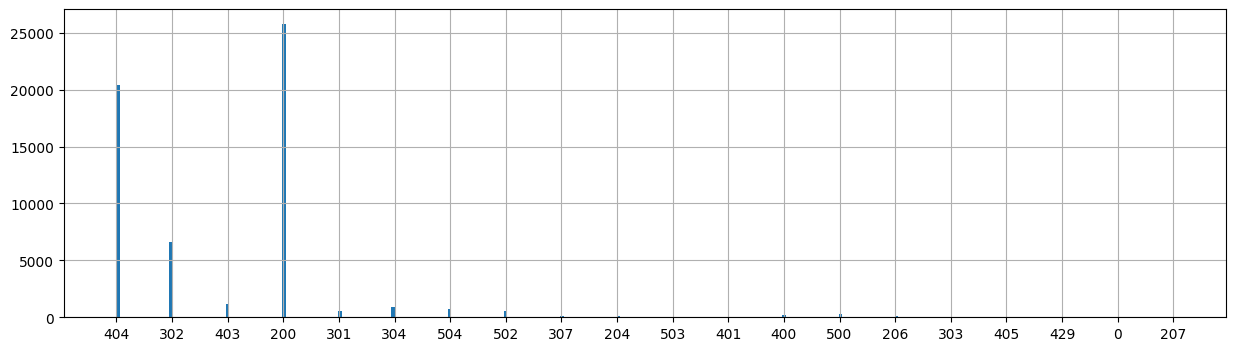

In [22]:
df[df.RESPONSE_CODE.str.len() < 4].RESPONSE_CODE.hist(bins=300, figsize=(15, 4))

### Ненормальные IP-адреса

Посмотрим записи, в которых адреса клиентов не похожи по формату на обычные IPv4 или IPv6.

In [23]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].shape

(115, 8)

Из интересных вхождений появилось ещё "Remote Code Execution"

In [24]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
162,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,4df2f46285c84ba39fa84fc4878214ae,NaN,NaN,NaN,NaN,NaN
1308,"~@.*"")ۅ",SQL Injection,AVdsla-3q1Ppo9zF_J7c,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN
1894,Remote Code Execution,AVddr1QQq1Ppo9zF3Vuj,0b168993dda4ce786f3455d01e162a58,NaN,NaN,NaN,NaN,NaN
1922,Ä}jSL 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,րÿ,AVdo4TiJq1Ppo9zF9OU0,NaN,NaN,NaN,NaN,NaN,NaN
3231,M{5¯ۯXµ #©نFî>R·8çp QÌû¿¼G̓X¿,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3344,Remote Code Execution,AVddRtA4q1Ppo9zF3E0u,f44ca434dfc32f17dff464956033f461,NaN,NaN,NaN,NaN,NaN
3671,¸#ØÓ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4144,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].CLIENT_USERAGENT.value_counts().head(5)

SQL Injection           35
Cross-Site Scripting     5
AVddXYBdq1Ppo9zF3IC6     1
AVdYVoMnq1Ppo9zF0VU9     1
AVdmgW85q1Ppo9zF8Gk4     1
Name: CLIENT_USERAGENT, dtype: int64

In [26]:
df[~df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)].CLIENT_IP.value_counts().head(5)

Remote Code Execution    19
f~|°ØÀ¶
g8%ú·P:V­     5
SQL Injection             4
¢×˾û8äyªû¬Aü           2
¿b_                      2
Name: CLIENT_IP, dtype: int64

Видно, что в данных "неправильного" формата упоминаются SQL Injection, Cross-Site Scripting, Remote Code Execution. Предположительно, это логи какой-то IDS, но пока непонятно, к каким записям они относятся, и как с этими записями их связать.

### Поле USERAGENT

Представиться можно любым узлом, поэтому маловероятно, что это поле будет признаком для поиска "настоящих" уязвимостей. Тем не менее, интересные штуки - например, для разметки и обучения - отсюда можно достать. Так, например, useragent OpenVAS (заметил при поиске XSS ниже) может быть условием для разметки записи как вредоносной. Понятно, что нормальный злоумышленник представляться OpenVAS'ом не будет (хотя почему бы и нет), но так мы хотя бы наберём больше данных.

In [27]:
df.head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp


In [28]:
df.CLIENT_USERAGENT.value_counts().head(10)

Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko                                                   2117
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36     1806
Mozilla/5.0 (compatible; AhrefsBot/5.2; +http://ahrefs.com/robot/)                                                     1805
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36    1677
Google Update/1.3.33.7;winhttp;cup-ecdsa                                                                               1537
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11           1304
MICROSOFT_DEVICE_METADATA_RETRIEVAL_CLIENT                                                                             1225
Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)                                                       1006
Mozilla/

### Запросы от OpenVAS

Посмотрим запросы от OpenVAS (вероятно, вредоносные) и посмотрим, что оттуда можно вытянуть. Сходу видны Path Traversal (../ или ..%2f)

In [29]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].MATCHED_VARIABLE_VALUE.shape

(464,)

In [30]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].MATCHED_VARIABLE_VALUE.head(5)

136    /otcdealsin/shopper.cgi?newpage=../../../../.....
144    /openmairie_Tel/scr/soustab.php?dsn[phptype]=....
347    /otcdeals/Scripts/ref/noty/charts.php?language...
388    /metalexp/frontend/js.php?module=../../../../....
480    /otcdeals/Scripts/ref/noty/cart.php?a=test&tem...
Name: MATCHED_VARIABLE_VALUE, dtype: object

Посмотрим, в какой части из них есть Path Traversal - оказалось, 446 строк из 480 от OpenVAS

In [31]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & (df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))].shape

(357, 8)

А в тех, которые от OpenVAS, но без явного PathTraversal: видны вызовы команд (grn.exe, ipconfig), SQL Injection (/d=/d), XSS ('\<script>alert()\</script>')

In [32]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))].MATCHED_VARIABLE_VALUE.head(20)

794                          /vbulletin/forum/content.php
1353    /buce/language/en/text.php/<script>alert(\'ope...
3050                                  /webmail/nameko.php
3529                                      /scripts/mw.exe
4366                                   /dolphin/index.php
4471                                         /SQLQHit.asp
4500                                                 ;id|
5049                                  /cgi-bin/.hg/branch
5543                           /_maincfgret.cgi_881227107
6008                                         /cbdb/db.exe
7621                                         /grn/grn.exe
7659         /error/pls/portal/PORTAL_DEMO.ORG_CHART.SHOW
7819                                           /mt/mt.cgi
8208                                  /cgi-shop/view_item
8275                                     file:///boot.ini
8449                              /metal/.git/description
8709                       /rips-scanner-master/index.php
8947          

Например, удалённый запуск EXE-файлов:

In [33]:
df[(df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) & (df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False))].MATCHED_VARIABLE_VALUE

3529     /scripts/mw.exe
6008        /cbdb/db.exe
7621        /grn/grn.exe
18945           /grn.exe
Name: MATCHED_VARIABLE_VALUE, dtype: object

А если нет ни PathTraversal, ни удалённого запуска команд, то видим, например, XSS

In [34]:
df[
    (df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False))
].MATCHED_VARIABLE_VALUE

794                           /vbulletin/forum/content.php
1353     /buce/language/en/text.php/<script>alert(\'ope...
3050                                   /webmail/nameko.php
4366                                    /dolphin/index.php
4471                                          /SQLQHit.asp
                               ...                        
54696                                     /error/bible.php
56988                                /gnat/admin/index.php
57130                       /admin/helpfiles/AdminHelp.php
57136            /nubuilder/productionnu2/fileuploader.php
57667                                /nodatabase/index.php
Name: MATCHED_VARIABLE_VALUE, Length: 103, dtype: object

Добъём запросы от OpenVAS и уберём ещё и XSS:

In [35]:
df[
    (df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.exe', na=False)) &
   ~(df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)) &
    ~(df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False))
].MATCHED_VARIABLE_VALUE.sample(20)

4366                                    /dolphin/index.php
8947                                   /kos2/changelog.txt
34303    /metalwh/www/loader.php/system/\"><iMg src=N o...
27352                                      /site/login.php
54696                                     /error/bible.php
21376                                    /db/budget.sqlite
29681                            /metalwh/.git/description
29308    /otcdeals/Scripts/ref/tipsy/www/loader.php/sys...
36335    /timbercutting/admin/login.php/\"onmouseover=a...
57667                                /nodatabase/index.php
7659          /error/pls/portal/PORTAL_DEMO.ORG_CHART.SHOW
19176                                    /phpmv2/index.php
22173                                           /kanboard/
41821                               /eds/.git/info/exclude
7819                                            /mt/mt.cgi
11620                                    /energine/htdocs/
17900                        /agriloader/.git/info/exclu

Также можно обратить внимание на код ответа - его распределение для (вероятно) вредоносных запросов сильно отличается от распределения для всего трафика.

In [36]:
df[df.CLIENT_USERAGENT.str.contains('OpenVAS', na=False)].RESPONSE_CODE.value_counts()

404    409
403     34
400      9
302      8
200      3
504      1
Name: RESPONSE_CODE, dtype: int64

Ниже разметим данные от OpenVAS (и не только), чтобы получить что-нибудь для тестирования

## Поиск вредоносных примеров (разметка)

Раз разметки найти не удалось, надо сделать её самостоятельно. Можно, конечно, пробовать кластеризацию, но в итоге всё равно нужно будет как-то измерять качество. А если делать это без разметки, то кластера могут получиться хорошо разделимые, но не нести никакой информации о вредоносности запроса...

Для каждого типа атаки будем создавать собственное поле, в котором False будет означать его отсутствие, а True - наличие. Использовать одно поле для всех неудобно, т.к. атаки могут пересекаться - например, сначала обход директорий, а потом запуск 

In [37]:
df['VULN'] = 0

In [38]:
df.head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2,0
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp,0


### Path Traversal

Начнём с того, что уже видели - обход директорий

In [39]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)].shape

(1458, 9)

Подпишем все такие запросы как вредоносные с соответствующим типом

In [40]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False), 'VULN'] = 'Path_Traversal'

In [41]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.\./', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
136,217.64.42.219,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",432,404,REQUEST_URI\';\'REQUEST_ARGS,newpage,/otcdealsin/shopper.cgi?newpage=../../../../.....,g-beAmQBjksgoq1efj7t,Path_Traversal
144,103.208.220.130,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",469,404,REQUEST_URI\';\'REQUEST_ARGS,dsn,/openmairie_Tel/scr/soustab.php?dsn[phptype]=....,L-f_AmQBjksgoq1eJ_hL,Path_Traversal
178,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,305,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.test,/../../../../../../../../../../../boot.ini\0,6MK7_mMBjksgoq1eD9Jb,Path_Traversal


Также символы для обхода директорий могут быть закодированы в URL (%2e%2e%2f, %2e%2e%2c - в зависимости от Windows/Linux и наклона слэша)

In [42]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
20705,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,210,404,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwinnt%...,84Yw22MBS0qQ_9B6De5U,0
27644,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,245,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cetc/passwd,RoOX2mMBS0qQ_9B6sQ0c,0
41255,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,250,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwindows/win.ini,0YTF2mMBS0qQ_9B6LhpQ,0
45748,216.218.222.11,curl/7.47.0,107,404,REQUEST_URI,NaN,///@.example.com/%2e%2e%2f,2FvUHGQB5cBXmMW1R_zV,0


In [43]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False), 'VULN'] = 'Path_Traversal'

In [44]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\%2e){2}(?:(?:\%2f)|(?:\%5c))', na=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
20705,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,210,404,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwinnt%...,84Yw22MBS0qQ_9B6De5U,Path_Traversal
27644,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,245,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cetc/passwd,RoOX2mMBS0qQ_9B6sQ0c,Path_Traversal
41255,172.31.1.19,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,250,301,REQUEST_URI,NaN,/%5c%2e%2e%5c%2e%2e%5c%2e%2e%5cwindows/win.ini,0YTF2mMBS0qQ_9B6LhpQ,Path_Traversal
45748,216.218.222.11,curl/7.47.0,107,404,REQUEST_URI,NaN,///@.example.com/%2e%2e%2f,2FvUHGQB5cBXmMW1R_zV,Path_Traversal


### XSS

Начнём просто с фильтра по тексту \<script>

In [45]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False), 'VULN'] = 'XSS'

In [46]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('<script>', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
436,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,320,302,REQUEST_GET_ARGS,test,X-Forwarded-For: <script>alert(1)</script>,gMTK_mMBjksgoq1eKBAM,XSS
1353,103.208.220.130,"Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)",445,400,REQUEST_PATH,NaN,/buce/language/en/text.php/<script>alert(\'ope...,_Of5AmQBjksgoq1evKw3,XSS
2990,178.235.13.219,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:49.0) ...,14209,200,REQUEST_POST_ARGS,pc[ads-5],"<script type=""text/javascript"">document.write(...",AVdlvY6Gq1Ppo9zF7kKo,XSS


### SQL Injection

Попробуем известные варианты. Начнём с "всегда истинное условие" (вроде 1=1)

Сначала глянем в целом два цифры по сторонам от '='. Видно, что непросто поймать регуляркой выражение из 66 записи "-1 OR 2+15-15-1=0+0+0+1". Наверно, можно их как-то считать, но пока пропустим, и выберем все

In [47]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\d=\d', regex=True, na=False)].shape

(1174, 9)

In [48]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\d=\d', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
31,178.65.190.208,Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...,1164,200,REQUEST_GET_ARGS,id,53 or 1=999999.9 /**/uNiOn/**/aLl /**/sElEcT 1...,AVdXraQsq1Ppo9zFz6OZ,0
39,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3795,307,REQUEST_COOKIES,REQUEST_COOKIES.rpx,"31956=70895,0,1,,&6286=70686,0,1,,&106496=7085...",QIEmIGQB5cBXmMW1qsEs,0
66,192.168.100.63,-1 OR 2+15-15-1=0+0+0+1,689,200,REQUEST_HEADERS,User-Agent,-1 OR 2+15-15-1=0+0+0+1,YPGiA2QBjksgoq1eQk68,0


Ещё нормальному разработчику незачем комментировать код в запросе. Посмотрим, есть ли такое в датасете:

P.S. Позже, при кластеризации и доразметке, добавил ещё `--` без пробелов

In [49]:
df[df.MATCHED_VARIABLE_VALUE.str.contains(' -- ', regex=True, na=False)].shape

(295, 9)

In [50]:
df[df.MATCHED_VARIABLE_VALUE.str.contains(' -- ', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
271,5.196.79.214,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,515,200,REQUEST_GET_ARGS,cat_num,3019999999999' or (select count(*)from(select ...,AVduM1tjq1Ppo9zF_3dR,0
459,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,855,200,REQUEST_GET_ARGS,SearchType,"2\"" AND \""\""1\""\""=\""\""2\""\"" -- \""",q7ZfEmQBoRd31uenp2_Y,0
461,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,606,302,REQUEST_COOKIES,gatetype,-1\' OR 2+444-444-1=0+0+0+1 --,fvGkA2QBjksgoq1eV2yx,0


Другим признаком SQL-инъекции может быть использование злоумышленником sleep() для обнаружения выполнения условия. Маловероятно, что sleep() будет использован разработчиком для умышленного замедления своего кода.

P.S. Ниже при кластеризации обнаружил, что можно (очевидно) использовать SLEEP в верхнем регистре, а ещё - WAITFOR. Там же (в разделе кластеризации и доразметки) и исправил.

In [51]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('sleep(?:.*)', regex=True, na=False)].shape

(255, 9)

In [52]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('sleep(?:.*)', regex=True, na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
252,91.216.126.128,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,1321,503,REQUEST_GET_ARGS,id,"5' aNd if(length(0x574352575653)>1,sleep(3),0)...",AVdrlJsXq1Ppo9zF-pvn,0
263,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,761,302,REQUEST_HEADERS,Via,k8fXJgJV\';select pg_sleep(6); --,rPGkA2QBjksgoq1eAGco,0
428,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,805,200,REQUEST_HEADERS,X-Forwarded-For,hXfWTHGV\';select pg_sleep(4); --,zfCbA2QBjksgoq1eMeZ0,0


Объединим все три условия и разметим как "SQL_Injection"

In [53]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\d=\d)|(?: -- )|sleep(?:.*)', na=False), 'VULN'] = 'SQL_Injection'

In [54]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?:\d=\d)|(?: -- )|sleep(?:.*)', na=False)].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN
31,178.65.190.208,Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...,1164,200,REQUEST_GET_ARGS,id,53 or 1=999999.9 /**/uNiOn/**/aLl /**/sElEcT 1...,AVdXraQsq1Ppo9zFz6OZ,SQL_Injection
39,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3795,307,REQUEST_COOKIES,REQUEST_COOKIES.rpx,"31956=70895,0,1,,&6286=70686,0,1,,&106496=7085...",QIEmIGQB5cBXmMW1qsEs,SQL_Injection
66,192.168.100.63,-1 OR 2+15-15-1=0+0+0+1,689,200,REQUEST_HEADERS,User-Agent,-1 OR 2+15-15-1=0+0+0+1,YPGiA2QBjksgoq1eQk68,SQL_Injection


P.S. Также при доразметке добавил `CHR`

## Обзор размеченных данных

Здесь посмотрим, коррелирует ли разметка данных с какими-нибудь признаками. И, может быть, доразметим.

In [55]:
df['VULN_BIN'] = np.where(df['VULN'] == 0, 0, 1)

In [56]:
df

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp,0,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0,0
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2,0,0
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp,0,0
...,...,...,...,...,...,...,...,...,...,...
57840,217.175.140.69,MICROSOFT_DEVICE_METADATA_RETRIEVAL_CLIENT,2402,302,REQUEST_XML,REQUEST_XML./s:Envelope/s:Body/DeviceMetadataB...,DOID:USBSTOR\\Imation_USB_Flash_Drive_2,tmtVHmQB5cBXmMW1MRdz,0,0
57841,109.206.151.20,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,922,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516440395935,Am-kHmQB5cBXmMW1YAcE,0,0
57842,89.23.32.19,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:57...,1453,404,REQUEST_COOKIES,REQUEST_COOKIES.User-cn,Николай Харченко,5lKlG2QB5cBXmMW1ghFl,0,0
57843,194.228.20.50,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,1550,200,REQUEST_POST_ARGS,REQUEST_POST_ARGS.s_Unids,688D71625B88803CC125818E00471A8D;9915FD3520134...,OsTJ_mMBjksgoq1e2QnM,0,0


Соотношение отмеченных "опасными" и неотмеченных строк

In [57]:
df['VULN'].value_counts()

0                 54948
SQL_Injection      1629
Path_Traversal     1231
XSS                  37
Name: VULN, dtype: int64

In [58]:
df['VULN_BIN'].value_counts()

0    54948
1     2897
Name: VULN_BIN, dtype: int64

### Очистка данных

Удалить некорректные данные

В которых:
1. Есть пропущенные значения
2. IP-адрес не совпадает по формату
3. Неправильные коды в RESPONSE_CODE

#### Неправильные адреса

Удалим строки, не подходящие по формату - такие, в которых IP-адрес не соответствует нормальному

In [59]:
df = df.loc[df.CLIENT_IP.str.contains('^(?:\d{1,3}.){3}\d{1,3}$|^(?:.{0,4}:){1,7}.{0,4}$', regex=True, na=False)]

In [60]:
df.shape

(57730, 10)

Посмотрим, какая часть данных имеет пропущенные значения

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57730 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57730 non-null  object
 1   CLIENT_USERAGENT        57436 non-null  object
 2   REQUEST_SIZE            57730 non-null  object
 3   RESPONSE_CODE           57730 non-null  object
 4   MATCHED_VARIABLE_SRC    57730 non-null  object
 5   MATCHED_VARIABLE_NAME   53167 non-null  object
 6   MATCHED_VARIABLE_VALUE  57683 non-null  object
 7   EVENT_ID                57666 non-null  object
 8   VULN                    57730 non-null  object
 9   VULN_BIN                57730 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


#### Обработка NaN

Посмотрим, какая часть "опасных" запросов содержит NaN'ы, и какая часть "нормальных" запросов их содержит

Среди "опасных" запросов

In [62]:
df[(df.isna().any(axis=1)) & (df.VULN_BIN == 1)].shape[0] / df[df.VULN_BIN == 1].shape[0]

0.18847083189506386

Среди "нормальных" запросов

In [63]:
df[(df.isna().any(axis=1)) & (df.VULN_BIN == 0)].shape[0] / df[df.VULN_BIN == 0].shape[0]

0.07575729943647073

Видно, что среди "опасных" таких в 3 раза больше (но помним, что мы выделили ещё не все "опасные", а только "избранные")

##### EVENT_ID

Видно, что некоторое количество данных не имеет EVENT_ID. Посмотрим, что это за данные.

In [64]:
df[df.EVENT_ID.isna()].head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
1431,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,93806,200,REQUEST_POST_ARGS,A,NaN,NaN,0,0
1921,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,113671,200,REQUEST_POST_ARGS,,©´Üf%<RS1N æ¦ LÔT´®ÎP·Ҥ,NaN,0,0
2552,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,93499,200,REQUEST_POST_ARGS,©æ(4È,NaN,NaN,0,0
3371,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,91927,200,REQUEST_POST_ARGS,©æ(4È,NaN,NaN,0,0
5308,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,91855,200,REQUEST_POST_ARGS,Õúj¾`2)*õrFÑEj)´úm^ 6O¤­¹ô,NaN,NaN,0,0


Видно, что NaN'ы появляются после строки с нарушенной кодировкой. Восстановить кодировку не удалось - ни по схеме из [статьи](https://habr.com/ru/post/147843/), ни перебором - видимо, что-то было упущено.

Глазами видно, что в строках с неуказанным EVENT_ID один и тот же CLIENT_USERAGENT. Проверим:

In [65]:
df[df.EVENT_ID.isna()].CLIENT_USERAGENT.value_counts()

curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0 OpenSSL/1.0.1 zlib/1.2.3.4 libidn/1.23 librtmp/2.3    63
uTorrent/348(110208592)(42576)                                                                        1
Name: CLIENT_USERAGENT, dtype: int64

In [66]:
df.MATCHED_VARIABLE_NAME.value_counts()

REQUEST_GET_ARGS._                                                 11165
REQUEST_COOKIES.LtpaToken2                                          3945
REQUEST_PATH                                                        3821
REQUEST_COOKIES.User-cn                                             2444
action                                                              2378
                                                                   ...  
DETAIL_TEXT                                                            1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vޡ¥%f®»                           1
srchPat%255B4%255D                                                     1
/content/goods/item[25]:Comment                                        1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8        1
Name: MATCHED_VARIABLE_NAME, Length: 3209, dtype: int64

Удалим строки, в которых не указан EVENT_ID

In [67]:
df = df.loc[~df.EVENT_ID.isna()]

##### MATCHED_VARIABLE_VALUE  

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57666 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57666 non-null  object
 1   CLIENT_USERAGENT        57372 non-null  object
 2   REQUEST_SIZE            57666 non-null  object
 3   RESPONSE_CODE           57666 non-null  object
 4   MATCHED_VARIABLE_SRC    57666 non-null  object
 5   MATCHED_VARIABLE_NAME   53104 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57666 non-null  object
 8   VULN                    57666 non-null  object
 9   VULN_BIN                57666 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Видно, что в MATCHED_VARIABLE_VALUE почти нет пропущенных значений. А те, которые есть, возникают из-за некорректного формата предыдущих строк

In [69]:
df[df.MATCHED_VARIABLE_VALUE.isna()]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
25322,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,181025,502,REQUEST_POST_ARGS,#¤õ6|йÁ_$SÏ}ØRÄvÉ#ڲÍæHNÖÚ ªGó«m4Çr...,NaN,AVdqSBQlq1Ppo9zF973f,0,0
35612,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,128783,200,REQUEST_POST_ARGS,_6_H$!,NaN,AVdeYBALq1Ppo9zF3yvf,0,0
50754,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,86799,200,REQUEST_POST_ARGS,¸õª¸ÏsX±ð*çvjcT°fåѺ¨) ú÷«¬ˀՀzUOZÈdûXz...,NaN,AVdm4Gy5q1Ppo9zF8W5w,0,0
51891,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,134389,200,REQUEST_POST_ARGS,øï¡üj\nPöZ·÷?AUÚÉIùfÚ,NaN,AVdfAvazq1Ppo9zF4KJR,0,0


Удалим такие строки:

In [70]:
df = df.loc[~df.MATCHED_VARIABLE_VALUE.isna()]

##### CLIENT_USERAGENT

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57368 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   53100 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


USERAGENT может быть подменён при отправке запроса. Возможно, это повлияет на данные, которые будет отдавать сервер, и, меняя useragent, злоумышленник получит что-то, к чему ранее доступа не имел, но пока такой вариант рассматривать не будем. В будущем можно было бы сопоставлять, например, IP и useragent на случай изменения последнего (но может быть и легальный сценарий - пользователь использует больше одного браузера или прячет истинный IP за NAT)

In [72]:
df[df.CLIENT_USERAGENT.isna()].head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,NaN,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
84,78.110.50.113,NaN,144,200,REQUEST_URI,NaN,/system/icons/eprodukt/656.jpg,AVdcb202q1Ppo9zF2li5,0,0
296,188.138.92.55,NaN,161,404,REQUEST_URI,NaN,//tmp/20160925057025indo.php.vob,AVdfv9FHq1Ppo9zF4j0t,0,0
612,87.242.64.149,NaN,75,200,REQUEST_URI,NaN,/system/galery/cameri/tki83rkd7v3i.jpg,AVdbGEZ8q1Ppo9zF1yNC,0,0
933,188.138.92.55,NaN,89,404,REQUEST_URI,NaN,//tmp/20160925122283indo.php.vob,AVdhW6rOq1Ppo9zF5Fsp,0,0


Заменим все пропущенные USERAGENT на default_useragent

In [73]:
df.loc[df.CLIENT_USERAGENT.isna(), 'CLIENT_USERAGENT'] = 'default_useragent'

##### MATCHED_VARIABLE_NAME

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   53100 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Остался последний столбец с пропусками - MATCHED_VARIABLE_NAME. Посмотрим, в каких данных пропуски

In [75]:
df[df.MATCHED_VARIABLE_NAME.isna()].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN
0,188.138.92.55,default_useragent,166,404,REQUEST_URI,NaN,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NaN,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0,0
8,94.50.192.153,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,3786,404,REQUEST_METHOD\';\'REQUEST_CONTE,NaN,POST\';\'multipart/form-data; boundary=----Web...,irs7_mMBjksgoq1eoQ7a,0,0


Посмотрим, какого формата бывают другие значения. Видно, что первая часть (описывающая общий класс) повторяется, а вторая более уникальна.

In [76]:
df.MATCHED_VARIABLE_NAME.value_counts()

REQUEST_GET_ARGS._                                                                                                                                                                                                             11165
REQUEST_COOKIES.LtpaToken2                                                                                                                                                                                                      3945
REQUEST_PATH                                                                                                                                                                                                                    3821
REQUEST_COOKIES.User-cn                                                                                                                                                                                                         2444
action                                                                              

Выделим первую часть в отдельный столбец - возможно, в будущем получится использовать как категориальную переменную

In [77]:
df['MATCHED_VARIABLE_NAME_FIRST'] = df['MATCHED_VARIABLE_NAME'].str.split('.').str[0]

Остаётся много вариантов VARIABLE_NAME. Можно было бы редкие заменить на самые популярные, и получить топ-50 вариантов, но пока оставим как есть, заменив NaN на заглушку

In [78]:
df.MATCHED_VARIABLE_NAME_FIRST.value_counts()

REQUEST_GET_ARGS                                                          17102
REQUEST_COOKIES                                                            8877
REQUEST_HEADERS                                                            4054
REQUEST_PATH                                                               3821
RESPONSE_HEADERS                                                           3185
                                                                          ...  
user_inc                                                                      1
¹8_%¶}ñ9FÁ
ëX(¶¯¦¾JÇ*çoÍfõJÊßæO$;#¬¤0¼øT?hûߠÿ                        1
itemid                                                                        1
COOKIE;COOKIE%3bnid%3b%2f%3b%2ennn%2eru;/cgi-bin/nph-r_cgi/;studioi_ru        1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8               1
Name: MATCHED_VARIABLE_NAME_FIRST, Length: 1847, dtype: int64

Удалим лишний столбец

In [79]:
df.drop(columns=['MATCHED_VARIABLE_NAME_FIRST'], inplace=True)

Заменим пропущенные значения на заглушку

In [80]:
df.loc[df.MATCHED_VARIABLE_NAME.isna(), 'MATCHED_VARIABLE_NAME'] = 'default_variable_name'

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


Пропущенных значений не осталось. Есть значения со странным форматом, но их обработаем далее - напрмер, с помощью n-gramm

#### Приведение к нужному типу

Для некоторых полей тип явно не подходит - например, REQUEST_SIZE определённо должен быть числом, чтобы можно было использовать его в модели. Как и RESPONSE_CODE - только последний должен быть категориальной переменной, потому что коды ответов не отличаются по "размеру"

- REQUEST_SIZE - числовой
- RESPONSE_CODE - категориальный
- MATCHED_VARIABLE_NAME - категориальный
- MATCHED_VARIABLE_VALUE - сделать BagOfWOrds (n-граммы по 2-3 символа)
- CLIENT_USERAGENT - тоже n-граммы
- CLIENT_IP - подумать

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  object
 3   RESPONSE_CODE           57662 non-null  object
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 4.6+ MB


In [83]:
df.REQUEST_SIZE.max()

'99956'

Сделаем длину запроса числом:

In [84]:
df.REQUEST_SIZE = df.REQUEST_SIZE.astype('int32')

Сделаем код ответа категорией:

In [85]:
df.RESPONSE_CODE = df.RESPONSE_CODE.astype('int32')  # category

In [86]:
df.RESPONSE_CODE.value_counts()

200    25707
404    20367
302     6630
403     1156
304      940
504      700
301      583
502      555
500      318
400      212
204      116
206       90
307       74
405       63
503       62
401       46
303       37
207        4
429        1
0          1
Name: RESPONSE_CODE, dtype: int64

In [87]:
df.RESPONSE_CODE.describe()

count    57662.000000
mean       300.488814
std         98.724767
min          0.000000
25%        200.000000
50%        302.000000
75%        404.000000
max        504.000000
Name: RESPONSE_CODE, dtype: float64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57662 entries, 0 to 57844
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57662 non-null  object
 1   CLIENT_USERAGENT        57662 non-null  object
 2   REQUEST_SIZE            57662 non-null  int32 
 3   RESPONSE_CODE           57662 non-null  int32 
 4   MATCHED_VARIABLE_SRC    57662 non-null  object
 5   MATCHED_VARIABLE_NAME   57662 non-null  object
 6   MATCHED_VARIABLE_VALUE  57662 non-null  object
 7   EVENT_ID                57662 non-null  object
 8   VULN                    57662 non-null  object
 9   VULN_BIN                57662 non-null  int32 
dtypes: int32(3), object(7)
memory usage: 4.2+ MB


Построить корреляции

<AxesSubplot:xlabel='VULN', ylabel='REQUEST_SIZE'>

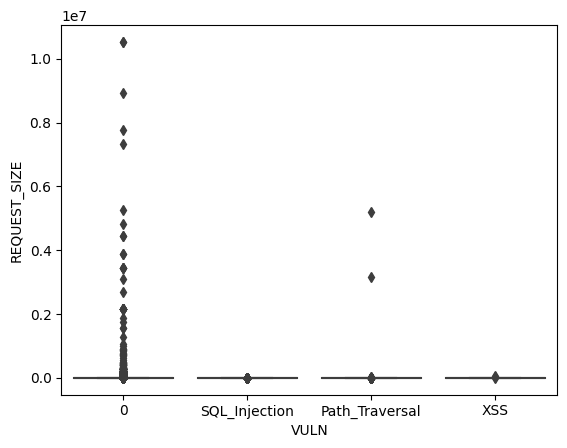

In [89]:
sns.boxplot(data=df, x='VULN', y='REQUEST_SIZE')

<AxesSubplot:xlabel='VULN', ylabel='RESPONSE_CODE'>

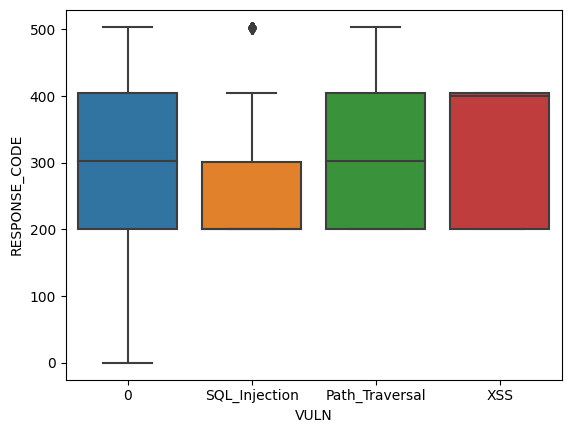

In [90]:
sns.boxplot(data=df, x='VULN', y='RESPONSE_CODE')

# Подход bag of words (с TF-IDF)

Задача похожа на задачу текстовой классификации. В качестве текстов - поле "MATCHED_VARIABLE_VALUE". Явного разделения на слова нет, поэтому будут использованы n-граммы.

## Подготовка данных

Разделение выборки на тренировочную и тестовую в пропорциях, соответствующих распределению классов. И выделение полной выборки для кластеризации

In [91]:
x_train, x_test, y_train, y_test = train_test_split(df.MATCHED_VARIABLE_VALUE, df.VULN_BIN, test_size=0.2, random_state=0, stratify=df.VULN_BIN)
x_all = df.MATCHED_VARIABLE_VALUE
y_all = df.VULN_BIN

Создание векторизатора (2- и 3-граммы)

In [92]:
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )

Расчёт частот встречаемости слов

In [93]:
x_all_counts = count_vect.fit_transform(x_all)

Для преобразования частот встречаемости n-грамм в каждом запросе в TF-IDF нужно знать частоты для всей выборки. Обучим преобразователь TF-IDF

In [94]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_all_counts)

Преобразуем исследуемые частоты появления слов в TF-IDF

In [95]:
x_all_tfidf = tfidf_transformer.transform(x_all_counts)

In [96]:
x_all_tfidf.shape

(57662, 500)

Аналогичную работу проведём для тренировочной выборки, чтобы в будущем обучить классификатор. Для тестовой сымитируем ситуацию, в которой векторизатор не видел новые (тестовые) n-граммы

In [97]:
%%time
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )
count_vect = count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_train_counts)
x_train_tfidf = tfidf_transformer.transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

Wall time: 12.8 s


## Понижение размерности

Попробуем уменьшить размерность полученного вектора, чтобы визуально оценить разделимость данных

PCA из sklearn не умеет работать с разреженными данными. Поэтому для него разожмём в массивы. Понизим размерность пространства признаков до трёхмерного

In [98]:
embedder_model = PCA(3)
x_pca = embedder_model.fit_transform(x_all_tfidf.toarray())

Нарисуем на картинке

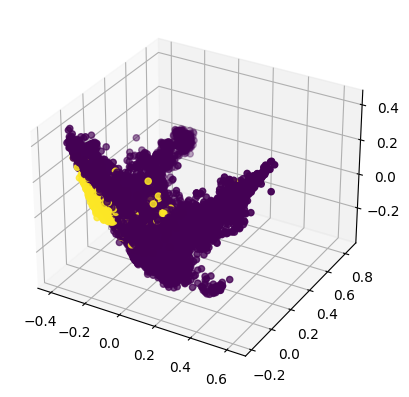

In [99]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=y_all)
plt.show()

И то же самое для отдельных выделенных классов

In [100]:
df.VULN.unique()

array([0, 'SQL_Injection', 'Path_Traversal', 'XSS'], dtype=object)

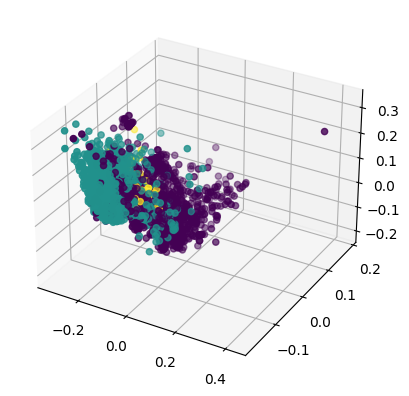

In [101]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=df.VULN.map({'SQL_Injection': 1, 'Path_Traversal': 2, 'XSS': 3}))
plt.show()

Попробуем то же самое в 2D

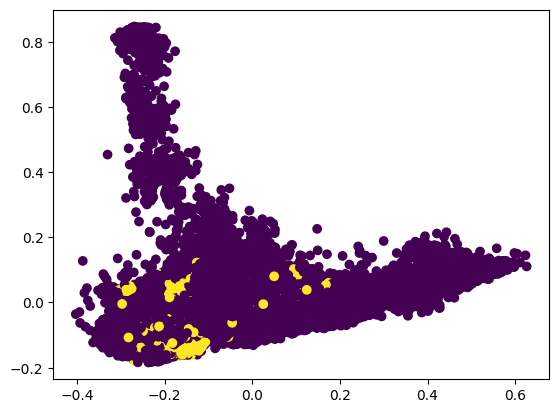

In [102]:
embedder_model = PCA(2)
x_pca = embedder_model.fit_transform(x_all_tfidf.toarray())
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_all)

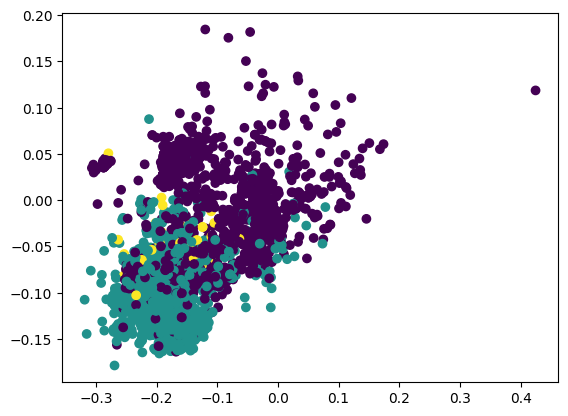

In [103]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=df.VULN.map({'SQL_Injection': 1, 'Path_Traversal': 2, 'XSS': 3}))

Видно, что, хотя часть данных и перемешана, всё равно классы визуально (после уменьшения размерности) разделяются.

## Кластеризация и доразметка

Попробуем кластеризовать имеющиеся данные, чтобы поискать, возможно, дополнительную разметку. Учитывая, что разметили не всю выборку - возможно, получится добавиь к выделенным атакам другие, которые будут замечены при попадании в такой кластер, где уже много атак.

### KMeans

#### Кластеризация

In [104]:
%%time
kmeans = KMeans(
        n_clusters=10,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_all_tfidf)

Wall time: 835 ms


Посмотрим, какая часть элементов в каждом кластере относится к вредоносной

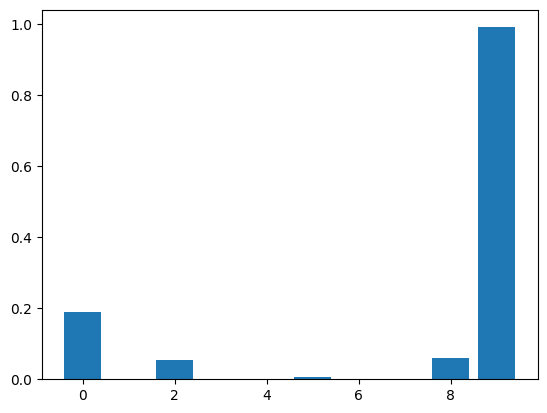

Количество элементов в каждом кластере: [ 2790  1998 10637  1464  4676 18190  1428  1039 14685   755]


In [105]:
df['CLUSTER_NUM'] = kmeans.labels_

df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Попробуем увеличить количство кластеров. Тут воспользовался подсказкой - оттуда взял предположение про 50 (хотя понятно, что это зависит от признаков)

In [106]:
kmeans = KMeans(
        n_clusters=50,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_all_tfidf)

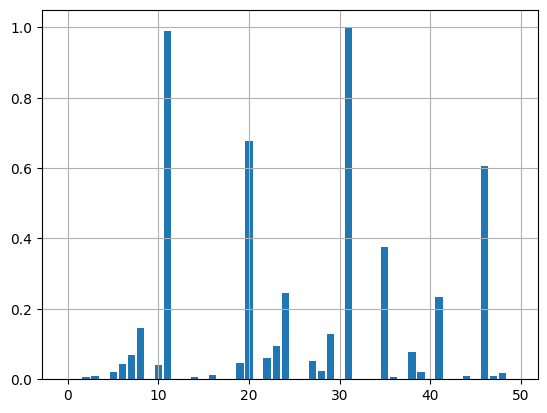

In [107]:
df['CLUSTER_NUM'] = kmeans.labels_
df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.grid()
plt.show()

Особенно интересно посмотреть на кластера №11, 20, 31, 35, 41, 46 - такие, в которых целевых около половины или больше

#### Доразметка

##### Кластер 11

Посмотрим, какие запросы попали в группу №11 (в которой почти 100% - запросы, размеченные как опасные)

In [108]:
df[df.CLUSTER_NUM == 11].VULN.value_counts()

Path_Traversal    706
SQL_Injection      37
0                   8
Name: VULN, dtype: int64

Видно, что это атаки PathTraversal, только на Windows - используется слэш, характерный для этой ОС (в кодировке - это %5C)

In [109]:
df[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
2069,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,737,200,REQUEST_ARGS,data_0,"{\""open\""\"":\""\""..\\/..\\/..\\/..\\/..\\/..\\/...",lO1kA2QBjksgoq1ekWS1,0,0,11
2895,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,557,400,REQUEST_URI,default_variable_name,/rich/..%5c..%5c..%5c..%5c..%5c..%5c..%5c..%5c...,w_CNA2QBjksgoq1ezR2k,0,0,11
14320,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,581,400,REQUEST_URI,default_variable_name,/zkau/web/56847ef8/zul/images/..%5c..%5c..%5c....,E--FA2QBjksgoq1eZ3aw,0,0,11
29411,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,313,302,REQUEST_HEADERS,Connection,..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C....,98K1_mMBjksgoq1eMWru,0,0,11
37075,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,580,400,REQUEST_URI,default_variable_name,/zkau/web/_zv2015121516/..%5c..%5c..%5c..%5c.....,oe-IA2QBjksgoq1es7x7,0,0,11
37293,95.161.153.34,Mozilla/5.0 Windows NT 6.3; Win64; x64 AppleWe...,318,302,REQUEST_HEADERS,Connection,..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C..%5C....,W8PA_mMBjksgoq1e4E59,0,0,11
39730,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,586,400,REQUEST_URI,default_variable_name,/zkau/web/174065ac/zul/images/..%5c..%5c..%5c....,BPGiA2QBjksgoq1eKk3K,0,0,11
51285,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,560,400,REQUEST_URI,default_variable_name,/js/..%5c..%5c..%5c..%5c..%5c..%5c..%5c..%5cwi...,je-EA2QBjksgoq1e8Wye,0,0,11


Доразметим все эти запросы как вредоносные:

In [110]:
df.loc[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0), 'VULN'] = 'Path_Traversal'
df.loc[(df.CLUSTER_NUM == 11) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

Кроме доразметки, получили немного оптимизма - похоже, наши признаки хоть что-то полезное выделяют

##### Кластер 20

Аналогично посмотрим на кластер №20

In [111]:
df[df.CLUSTER_NUM == 20].VULN.value_counts()

Path_Traversal    141
0                  68
SQL_Injection       2
Name: VULN, dtype: int64

В глаза бросается только /etc/passwd. Обращение к этому файлу - не норма для обычного запроса.

In [112]:
df[(df.CLUSTER_NUM == 20) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
565,31.13.20.30,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,823,200,REQUEST_URI,default_variable_name,/etc/pic3518s.jpg,AVdXdiPxq1Ppo9zFzv4k,0,0,20
1316,54.36.150.23,Mozilla/5.0 (compatible; AhrefsBot/5.2; +http:...,235,302,REQUEST_PATH,REQUEST_PATH,/search/public/ru/DOWNLOAD_IMAGE49/{{_cabinetL...,TU5HG2QB5cBXmMW1PPXp,0,0,20
5229,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,755,301,REQUEST_GET_ARGS,REQUEST_GET_ARGS.query,query;cat /etc/passwd;,DLMREmQBoRd31uenAIdZ,0,0,20
5945,178.217.110.17,Mozilla/5.0 (X11; CrOS x86_64 8530.81.0) Apple...,880,200,REQUEST_URI,default_variable_name,/etc/pic3382s.jpg,AVdmuf3Lq1Ppo9zF8Pqf,0,0,20
6717,68.180.228.240,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,195,200,REQUEST_URI,default_variable_name,/etc/pic140b.jpg,AVdbFFa9q1Ppo9zF1xyQ,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...
57239,185.19.21.252,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,759,200,REQUEST_URI,default_variable_name,/etc/pic3593s.jpg,AVdYKaAzq1Ppo9zF0OOU,0,0,20
57430,213.87.149.62,Mozilla/5.0 (iPhone; CPU iPhone OS 6_1_2 like ...,906,200,REQUEST_URI,default_variable_name,/etc/pic390s.jpg,AVdYac3Pq1Ppo9zF0X-C,0,0,20
57508,5.143.231.38,Mozilla/5.0 (compatible; SputnikBot/2.3; +http...,646,200,REQUEST_PATH,REQUEST_PATH,/sitemap/public/ru/med/{{_cabinetLink}}/access...,0Z1qImQB5cBXmMW1qR0T,0,0,20
57627,213.87.146.135,Mozilla/5.0 (Linux; Android 6.0.1; SGP621 Buil...,805,200,REQUEST_URI,default_variable_name,/etc/pic446s.jpg,AVdWiJy0q1Ppo9zFzAdF,0,0,20


Доразметим данные - пусть все неразмеченные обращения к /etc/passwd будут опасными. Хотя их и оказалось не так много.

In [113]:
df[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
1479,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,646,404,REQUEST_URI,default_variable_name,/css/%c0%ae%c0%ae/%c0%ae%c0%ae/%c0%ae%c0%ae/%c...,Z-50A2QBjksgoq1eTFPh,0,0,6
5229,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,755,301,REQUEST_GET_ARGS,REQUEST_GET_ARGS.query,query;cat /etc/passwd;,DLMREmQBoRd31uenAIdZ,0,0,20
14856,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,805,404,REQUEST_URI,default_variable_name,/css/%c0%ae%c0%ae%c1%9c%c0%ae%c0%ae%c1%9c%c0%a...,jO1vA2QBjksgoq1eJ_HM,0,0,6
23162,192.168.100.63,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,660,404,REQUEST_URI,default_variable_name,/zkau/web/174065ac/%c0%ae%c0%ae/%c0%ae%c0%ae/%...,Uu-KA2QBjksgoq1epOhY,0,0,6
23699,193.169.34.155,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:52.0) G...,223,404,REQUEST_ARGS,amp;nn,`/etc/passwd`,voJ02mMBS0qQ_9B6hjdL,0,0,20


In [114]:
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0), 'VULN'] = 'Path_Traversal'
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('/etc/passwd')) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

Заодно посмотрим ещё и обращения к скриптам.

In [115]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')].MATCHED_VARIABLE_VALUE

2472     /bin/HS55i56jGB3bSAIi.sh
2491     /bin/PvO3tauSA9PatKGv.sh
15138    /bin/ljDFqjM47K1qCR0j.sh
23278    /bin/u79k8ojFq5C7GDX5.sh
24264    /bin/4K09ib44JPGAG33d.sh
43819    /bin/210Fs65Pto8KA7h0.sh
55736    /bin/oHVb35ul8gh9iGvG.sh
55923    /bin/iguS3G0of2hM7x4V.sh
Name: MATCHED_VARIABLE_VALUE, dtype: object

Тоже доразметим их как вредоносные

In [116]:
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')) & (df.VULN_BIN == 0), 'VULN'] = 'Remote_Code_Execution'
df.loc[(df.MATCHED_VARIABLE_VALUE.str.contains('\.sh$')) & (df.VULN_BIN == 0), 'VULN_BIN'] = 1

##### Кластер 31

Тут всё просто - все выделенные записи относятся к размеченным вредоносным:

In [117]:
df[df.CLUSTER_NUM == 31].VULN.value_counts()

SQL_Injection     100
Path_Traversal     25
Name: VULN, dtype: int64

Но посмотрим, почему они похожи (классы-то атак разные). Похоже, что по трём точкам - какой-то странный формат сжатия строки.

In [118]:
df[(df.CLUSTER_NUM == 31) & (df.VULN == 'SQL_Injection')].MATCHED_VARIABLE_VALUE

987      /software/downl.../ftp.drweb.com/pub/drweb/win...
1048     /software/downl.../ftp.drweb.com/pub/drweb/win...
1711     /software/downl.../ftp.drweb.com/pub/drweb/win...
2061     /software/downl.../ftp.drweb.com/pub/drweb/win...
2178     /software/downl.../ftp.drweb.com/pub/drweb/win...
                               ...                        
55731    /software/downl.../ftp.drweb.com/pub/drweb/win...
56542    /software/downl.../ftp.drweb.com/pub/drweb/win...
56945    /software/downl.../ftp.drweb.com/pub/drweb/win...
57049    /software/downl.../ftp.drweb.com/pub/drweb/win...
57287    /software/downl.../ftp.drweb.com/pub/drweb/win...
Name: MATCHED_VARIABLE_VALUE, Length: 100, dtype: object

In [119]:
print(df[(df.CLUSTER_NUM == 31) & (df.VULN == 'Path_Traversal')].MATCHED_VARIABLE_VALUE)

536                                /news.../page1_2490.php
647                                 /news.../page1_140.php
1802     /software/downl.../ftp.drweb.com/pub/drweb/win...
3586     /software/downl.../ftp.drweb.com/pub/drweb/win...
11156                                /news.../page1_81.php
11893                              /news.../page1_2619.php
13635    /software/downl.../ftp.drweb.com/pub/drweb/win...
15129    /software/downl.../ftp.drweb.com/pub/drweb/win...
15313    /software/downl.../ftp.drweb.com/pub/drweb/win...
24263    /software/downl.../ftp.drweb.com/pub/drweb/win...
25965    /software/downl.../ftp.drweb.com/pub/drweb/win...
27077    /software/downl.../ftp.drweb.com/pub/drweb/win...
29838                               /news.../page1_224.php
30394                                 /news.../page1_6.php
31400    /software/downl.../ftp.drweb.com/pub/drweb/win...
35441    /software/downl.../ftp.drweb.com/pub/drweb/win...
36646                                 /news.../page1_2.p

##### Кластер 35

Тут бОльшая часть данных не размечена, но интересно, что из всех типов опасных запросов здесь выделился только один - SQL Injection:

In [120]:
df[df.CLUSTER_NUM == 35].VULN.value_counts()

0                240
SQL_Injection    144
Name: VULN, dtype: int64

Посмотрим неразмеченные данные этого класса:

In [121]:
df[(df.CLUSTER_NUM == 35) & (df.VULN_BIN == 0)].MATCHED_VARIABLE_VALUE

48       3 AND ORD(MID((SELECT IFNULL(CAST(email AS CHA...
1393     3 and if(ascii(substring((select distinct tabl...
1555     3 and if(ascii(substring((select distinct tabl...
1650     0;insert into users (uid,name,pass,mail,status...
1971     (select 1=updatexml(1,concat(0x5e24,(select le...
                               ...                        
57216    999999.9 union all select 0x313032353438303035...
57507    I have my own business <a href=" http://marell...
57570    0;insert into users (uid,name,pass,mail,status...
57668    14' and if(((/*!SelEcT*/ conv(substring(hex(ca...
57734    14' and if(((/*!SelEcT*/ conv(substring(hex(ca...
Name: MATCHED_VARIABLE_VALUE, Length: 240, dtype: object

Попробуем ещё раз кластеризовать данные, только уже внутри этого кластера. И для тех субкластеров, в которых больше 80% запросов будет размечено "вредоносными", остальные тоже разметим как вредоносные - хорошо, что тип в этом кластере (35) всего один - SQL Injection

Данные для разделения - объекты внутри этого кластера

In [122]:
df_tmp = df.loc[df.CLUSTER_NUM == 35]
x_small_tfidf = x_all_tfidf[np.where(kmeans.labels_ == 35)[0]]
x_small_tfidf.shape

(384, 500)

In [123]:
%%time
kmeans_group_35 = KMeans(
        n_clusters=10,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_small_tfidf)

Wall time: 15.5 ms


Добавим ещё один столбец - номер кластера в новом разбиении

C:\Users\asinadskiy\AppData\Local\Temp\ipykernel_11600\637889159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['subgroup_in_group_35'] = kmeans_group_35.labels_


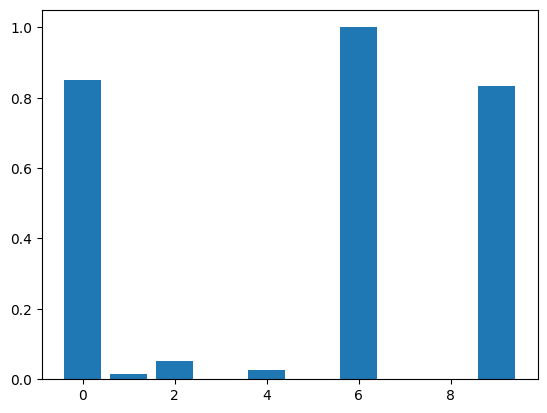

Количество элементов в каждом кластере: [146  62  38  30  36  17  11  15  23   6]


In [124]:
df_tmp['subgroup_in_group_35'] = kmeans_group_35.labels_

df_grp = df_tmp.groupby('subgroup_in_group_35')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans_group_35.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Разметим все элементы, попавшие в субкластер с большой долей размеченных "вредоносных" запросов, как "вредоносные":

In [125]:
df.loc[
    df.index.isin(df_tmp[df_tmp.subgroup_in_group_35.isin([0, 6, 9]) & (df_tmp.VULN_BIN == 0)].index), 'VULN'
] = 'SQL_Injection'

df.loc[
    df.index.isin(df_tmp[df_tmp.subgroup_in_group_35.isin([0, 6, 9]) & (df_tmp.VULN_BIN == 0)].index), 'VULN_BIN'
] = 1

##### Кластер 41

In [126]:
df[df.CLUSTER_NUM == 41].VULN.value_counts()

0                 577
SQL_Injection     170
Path_Traversal      5
XSS                 2
Name: VULN, dtype: int64

Тут ситуация аналогична 35 кластеру. Поступим так же - доразметим те запросы, которые оказались в кластере с большим количеством размеченных вредоносных

In [127]:
df_tmp = df.loc[df.CLUSTER_NUM == 41]
x_small_tfidf = x_all_tfidf[np.where(kmeans.labels_ == 41)[0]]
x_small_tfidf.shape

(754, 500)

In [128]:
%%time
kmeans_group_41 = KMeans(
        n_clusters=8,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_small_tfidf)

Wall time: 15.6 ms


Как и в 35 кластере, добавим ещё один столбец - номер кластера в новом разбиении

C:\Users\asinadskiy\AppData\Local\Temp\ipykernel_11600\43146603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['subgroup_in_group_41'] = kmeans_group_41.labels_


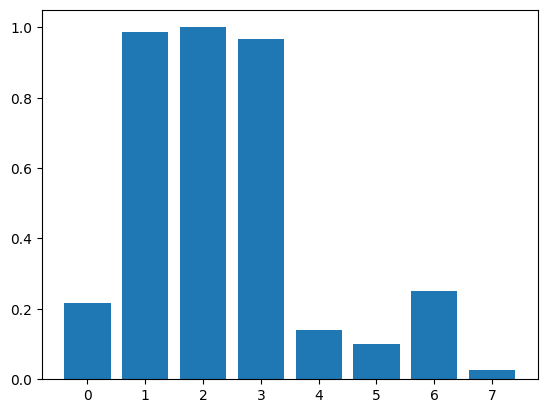

Количество элементов в каждом кластере: [ 23  68  11  30 135 445   4  38]


In [129]:
df_tmp['subgroup_in_group_41'] = kmeans_group_41.labels_

df_grp = df_tmp.groupby('subgroup_in_group_41')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans_group_41.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Посмотрим примеры, попавшие в "вредоносные" кластера

In [130]:
df_tmp[df_tmp.subgroup_in_group_41.isin([1, 2, 3]) & (df_tmp.VULN_BIN == 0)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM,subgroup_in_group_41
34744,89.106.175.18,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,565,200,REQUEST_GET_ARGS,\' or 1,\' or 1,MOKoAmQBjksgoq1e-a_R,0,0,41,1
47734,192.168.103.70,sqlmap/1.1.4.18#dev (http://sqlmap.org),370,404,REQUEST_GET_ARGS,ID,666\' AND SLEEP(10) AND \'hXPC\'=\'hXPC,JWKQHWQB5cBXmMW1crp_,0,0,41,3


Доразметим их:

In [131]:
df.loc[
    df.index.isin(df_tmp[df_tmp.subgroup_in_group_41.isin([1, 2, 3]) & (df_tmp.VULN_BIN == 0)].index), 'VULN'
] = 'SQL_Injection'

df.loc[
    df.index.isin(df_tmp[df_tmp.subgroup_in_group_41.isin([1, 2, 3]) & (df_tmp.VULN_BIN == 0)].index), 'VULN_BIN'
] = 1

Теперь посмотрим примеры, попавшие в "безопасные" кластера:

In [132]:
df[
    df.index.isin(df_tmp[df_tmp.subgroup_in_group_41.isin([5]) & (df_tmp.VULN_BIN == 0)].index)
].head(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,VULN,VULN_BIN,CLUSTER_NUM
383,178.70.234.106,sqlmap/1.2.1.18#dev (http://sqlmap.org),337,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.id,1049%\' WAITFOR DELAY \'0:0:5\' AND \'%\'=\',KKqOI2QB5cBXmMW1itj_,0,0,41
423,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3886,200,REQUEST_COOKIES,anj,dTM7k!M4/K@MNlhjN9HN_LLkLl:0NW`gOG)G]lP6c%nb7m...,OmtXHmQB5cBXmMW1vjhL,0,0,41
463,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,4895,504,REQUEST_ARGS,anj,dTM7k!M4/KU$GZDjN8p^W\'W05E*u.jP`HR51PtVOFGG6E...,0VvFHGQB5cBXmMW1H3GN,0,0,41


Видно, что при начальной разметке SQL Injection были пропущены заглавные буквы в SLEEP и конструкция WAITFOR, которая тоже может быть элементом слепой SQL инъекции. Причём она может быть использована не обязательно с DELAY.

Доразметим во всей выборке записи, содрежащие SLEEP и WAITFOR в любом регистре (?i) как SQL Injection:

Посмотрим, сколько таких (со SLEEP/SleeP/etc) было пропущено:

In [133]:
df[
    ~df.MATCHED_VARIABLE_VALUE.str.contains('sleep(?:.*)', regex=True, na=False) &
    df.MATCHED_VARIABLE_VALUE.str.contains('(?i)sleep(?:.*)', regex=True, na=False)
].shape

(102, 11)

Доразметим их как SQL_Injection

In [134]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)sleep(?:.*)', na=False), 'VULN'] = 'SQL_Injection'
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)sleep(?:.*)', na=False), 'VULN_BIN'] = 1

То же самое сделаем с WAITFOR:

In [135]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)WAITFOR', regex=True, na=False)].shape

(100, 11)

In [136]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)WAITFOR', na=False), 'VULN'] = 'SQL_Injection'
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)WAITFOR', na=False), 'VULN_BIN'] = 1

##### Кластер 46

In [137]:
df[df.CLUSTER_NUM == 46].VULN.value_counts()

SQL_Injection    315
0                 72
Name: VULN, dtype: int64

C:\Users\asinadskiy\AppData\Local\Temp\ipykernel_11600\911459836.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['subgroup_in_group_46'] = kmeans_group_46.labels_


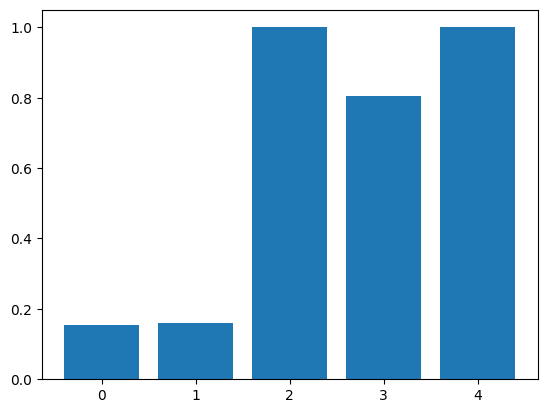

Количество элементов в каждом кластере: [ 98 502  71  72  11]


In [138]:
df_tmp = df.loc[df.CLUSTER_NUM == 41]
x_small_tfidf = x_all_tfidf[np.where(kmeans.labels_ == 41)[0]]

kmeans_group_46 = KMeans(
        n_clusters=5,
        max_iter=100,
        n_init=1,
        random_state=0,
    ).fit(x_small_tfidf)

df_tmp['subgroup_in_group_46'] = kmeans_group_46.labels_

df_grp = df_tmp.groupby('subgroup_in_group_46')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(kmeans_group_46.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Посмотрим примеры из кластера, в котором не все, но большая часть - размеченные вредоносные запросы:

In [139]:
df_tmp[(df_tmp.subgroup_in_group_46 == 3) & (df_tmp.VULN_BIN == 0)].MATCHED_VARIABLE_VALUE

5159     1%\' AND 8904=DBMS_PIPE.RECEIVE_MESSAGE(CHR(11...
8290     1\') AND 8383=DBMS_PIPE.RECEIVE_MESSAGE(CHR(77...
15514                   rsd\') UNION ALL SELECT NULL,NULL#
17153                    rsd\' UNION ALL SELECT NULL,NULL#
20092                 5021%\' UNION ALL SELECT NULL-- NXFw
22158                  special AND USER_NAME() = \'admin\'
30184                      /\' UNION ALL SELECT NULL,NULL#
33765                  1049\' UNION ALL SELECT NULL-- eYHh
35304                  583%\' UNION ALL SELECT NULL-- HljT
36927    3840%\' AND 6931=DBMS_PIPE.RECEIVE_MESSAGE(CHR...
37632                    1\') UNION ALL SELECT NULL-- LkuV
39838    1\' AND 8904=DBMS_PIPE.RECEIVE_MESSAGE(CHR(115...
41731                   rsd\' UNION ALL SELECT NULL-- ohUW
50363    /\') AND 5389=DBMS_PIPE.RECEIVE_MESSAGE(CHR(11...
Name: MATCHED_VARIABLE_VALUE, dtype: object

In [140]:
df.loc[8290].MATCHED_VARIABLE_VALUE

"1\\') AND 8383=DBMS_PIPE.RECEIVE_MESSAGE(CHR(77)||CHR(68)||CHR(113)||CHR(72),5) AND (\\'mmgu\\'=\\'mmgu"

In [141]:
df.loc[50363].MATCHED_VARIABLE_VALUE

"/\\') AND 5389=DBMS_PIPE.RECEIVE_MESSAGE(CHR(112)||CHR(68)||CHR(111)||CHR(107),5) AND (\\'fojx\\'=\\'fojx"

Обнаружились неучтённые варианты SQL инъекций - CHR, комментарий без пробелов вокруг (ранее учитывался только `' -- '`).

In [142]:
df[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)CHAR|CHR', regex=True, na=False)].shape

(2567, 11)

In [143]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)CHAR|CHR', na=False), 'VULN'] = 'SQL_Injection'
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)CHAR|CHR', na=False), 'VULN_BIN'] = 1

С комментарием чуть сложнее - не всегда строка `--` относится к SQL - например, она может быть частью названия другого файла, элементом составного запроса или ещё чего-то. Поэтому комментарий будем искать только в сочетании с явным SQL

In [144]:
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)(SELECT|UPDATE|DELETE|INSERT|CREATE|ALTER|UNION|JOIN).*--', regex=True, na=False), 'VULN'] = 'SQL_Injection'
df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)(SELECT|UPDATE|DELETE|INSERT|CREATE|ALTER|UNION|JOIN).*--', regex=True, na=False), 'VULN_BIN'] = 1

C:\Users\asinadskiy\AppData\Local\Temp\ipykernel_11600\1677099331.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)(SELECT|UPDATE|DELETE|INSERT|CREATE|ALTER|UNION|JOIN).*--', regex=True, na=False), 'VULN'] = 'SQL_Injection'
C:\Users\asinadskiy\AppData\Local\Temp\ipykernel_11600\1677099331.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df.MATCHED_VARIABLE_VALUE.str.contains('(?i)(SELECT|UPDATE|DELETE|INSERT|CREATE|ALTER|UNION|JOIN).*--', regex=True, na=False), 'VULN_BIN'] = 1


Можно было бы ещё посмотреть данные. Но для ускорения попробуем ещё DBSCAN и далее перейдём к созданию самой предсказывающей модели.

### Результат доразметки

В результате доразметки данных обновилась разметка. Поэтому нужно заново разметить y_train и y_test. Какие вектора отнесены к train, а какие к test - неизвестно, поэтому просто создадим новые тренировочную и тестовую выборки.

In [145]:
x_train, x_test, y_train, y_test = train_test_split(df.MATCHED_VARIABLE_VALUE, df.VULN_BIN, test_size=0.2, random_state=0, stratify=df.VULN_BIN)
x_all = df.MATCHED_VARIABLE_VALUE
y_all = df.VULN_BIN

Создание векторизатора (2- и 3-граммы)

In [146]:
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )

Расчёт частот встречаемости слов

In [147]:
x_all_counts = count_vect.fit_transform(x_all)

Для преобразования частот встречаемости n-грамм в каждом запросе в TF-IDF нужно знать частоты для всей выборки. Обучим преобразователь TF-IDF

In [148]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_all_counts)

Преобразуем исследуемые частоты появления слов в TF-IDF

In [149]:
x_all_tfidf = tfidf_transformer.transform(x_all_counts)

In [150]:
x_all_tfidf.shape

(57662, 500)

Аналогичную работу проведём для тренировочной выборки, чтобы в будущем обучить классификатор. Для тестовой сымитируем ситуацию, в которой векторизатор не видел новые (тестовые) n-граммы

In [151]:
%%time
count_vect = CountVectorizer(lowercase=False,  # URL чувствительны к регистру
                             max_features=500,  # отбросим редко появляющиеся признаки
                             ngram_range=(2,3),
                             analyzer='char',
                            )
count_vect = count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_train_counts)
x_train_tfidf = tfidf_transformer.transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

Wall time: 12.5 s


### DBSCAN

In [152]:
%%time
dbscan = DBSCAN(
        eps=0.8,
        min_samples=5,
        n_jobs=-1
    ).fit(x_all_tfidf)

Wall time: 1min 43s


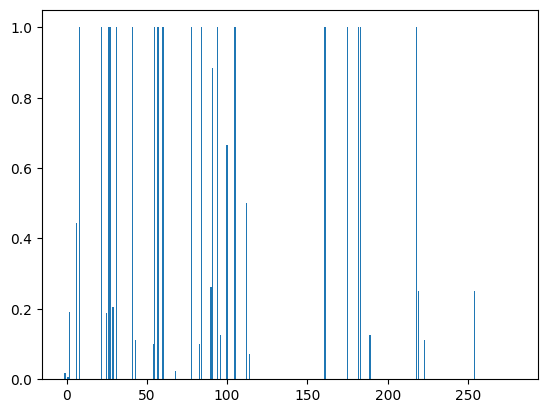

Количество элементов в каждом кластере: [22750    87  1366 22677    98    40  3524     9   366    16     8     5
   101   148    62     9    27    25   860    31    84    15    18    43
     6    15    16    20   221     5   204    20     6   186    14   124
    10     4   100    37   490    62    11    24     9    38     9   284
     6   354    23     5    15    23    65   160   112    15    74    15
    74    10     5    15    34     5    11   141     6    43     8     5
   117    11    36    77     5    11    20    26    16     6    19     6
    10    14    17    13    10     6    27    19    61    17     5     6
    19     8     7    33    61     6    43     4    20     8    10    18
     7     4    22    14    10     8    15    14     7    49     7    13
     5    11    13    13     8    17     9     8     8    32    13     7
    12    13     7     5     6     9    11    12     9     9    10    14
     5    14    22     5     5    12    16     8     6     7     4     7
     7     

In [153]:
df['CLUSTER_NUM'] = dbscan.labels_

df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

Посмотрим, какая часть кластеров содержит только (или почти только) безопасные запросы, какая - смешанные, и какая - опасные.

Видно, что запросы разделяются. Есть ещё несколько кластеров, в которых данные смешались, и для улучшения качества модели можно было бы их доразметить.

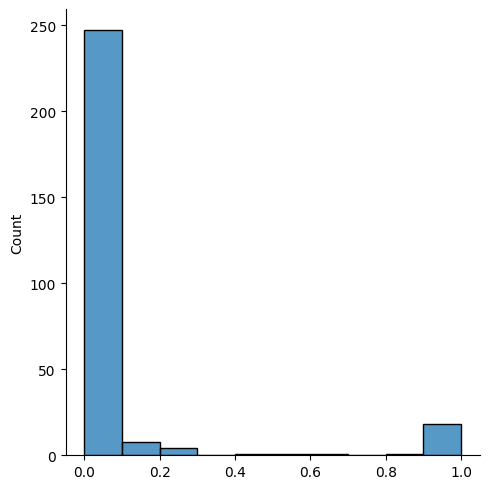

In [154]:
sns.displot(part_vuln_in_group, bins = 10)

## Бинарная классификация

Какая-то разметка уже подготовлена, теперь можно попробовать собрать модель. Для начала используем самый простой вариант - без дополнительных признаков только по тем TF-IDF, которые нагенерированы выше.

В качестве метрики будем смотреть на recall, чтобы пропустить минимум "опасных" запросов (минимизировать ложноотрицательные предсказания)

### Наивный байесовский классификатор

Начнём с наивного байесовского классификатора - он оценивает влияние каждого признака в отдельности в предположении, что признаки не зависят друг от друга

In [155]:
%%time
clf = MultinomialNB().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10419
           1       0.82      0.75      0.78      1114

    accuracy                           0.96     11533
   macro avg       0.90      0.87      0.88     11533
weighted avg       0.96      0.96      0.96     11533

Wall time: 15.6 ms


In [156]:
%%time
clf = ComplementNB().fit(x_train_tfidf.toarray(), y_train)
y_pred = clf.predict(x_test_tfidf.toarray())
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10419
           1       0.54      0.86      0.66      1114

    accuracy                           0.92     11533
   macro avg       0.76      0.89      0.81     11533
weighted avg       0.94      0.92      0.92     11533

Wall time: 154 ms


### К-ближайших соседей

In [157]:
%%time
model = KNeighborsClassifier(n_neighbors=5).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf.toarray())
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10419
           1       0.54      0.86      0.66      1114

    accuracy                           0.92     11533
   macro avg       0.76      0.89      0.81     11533
weighted avg       0.94      0.92      0.92     11533

Wall time: 53.5 ms


### SVM

Разделяющие плоскости в n-мерном пространстве

In [158]:
%%time
clf = SVC().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10419
           1       0.97      0.93      0.95      1114

    accuracy                           0.99     11533
   macro avg       0.98      0.96      0.97     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 1min 39s


### Деревья

Набор условий, создаваемый по максимальной информативности

In [159]:
%%time
clf = DecisionTreeClassifier().fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10419
           1       0.94      0.94      0.94      1114

    accuracy                           0.99     11533
   macro avg       0.96      0.97      0.97     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 5.48 s


### Случайный лес

Набор деревьев, исследующих разные наборы признаков

In [160]:
%%time
clf = RandomForestClassifier(max_depth=50, max_features=0.75,
                             n_jobs=-1, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10419
           1       0.98      0.94      0.96      1114

    accuracy                           0.99     11533
   macro avg       0.99      0.97      0.98     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 57.8 s


### Extremely Randomized Trees

In [161]:
%%time
clf = ExtraTreesClassifier(bootstrap=False, max_features=0.75, min_samples_split=9,
                          n_jobs=-1, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10419
           1       0.99      0.94      0.96      1114

    accuracy                           0.99     11533
   macro avg       0.99      0.97      0.98     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 43.2 s


### AdaBoost

Бустинг (поправка на неправильно классифицированных запросах)

In [162]:
%%time
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10419
           1       0.95      0.91      0.93      1114

    accuracy                           0.99     11533
   macro avg       0.97      0.95      0.96     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 12.9 s


## Выбранная модель

В качестве итоговой модели будет использована модель сверхслучайных деревьев - он показал достаточно хороший результат, должен быть стабилен (результат оценивается независимо по всем признакам), достаточно быстро работает.

In [163]:
%%time
clf = ExtraTreesClassifier(bootstrap=False, max_features=0.75, min_samples_split=9,
                          n_jobs=-1, random_state=0).fit(x_train_tfidf, y_train)
y_pred = clf.predict(x_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10419
           1       0.99      0.94      0.96      1114

    accuracy                           0.99     11533
   macro avg       0.99      0.97      0.98     11533
weighted avg       0.99      0.99      0.99     11533

Wall time: 39.3 s


Для использования в веб-сервисе обучим модель на всём наборе данных:

In [164]:
%%time
clf = ExtraTreesClassifier(bootstrap=False, max_features=0.75, min_samples_split=9,
                          n_jobs=-1, random_state=0).fit(x_all_tfidf, y_all)

Wall time: 1min 5s


Повторим предсказания для обучающих данных (посмотрим, как модель их зампомнила)

In [165]:
joblib.dump(clf, 'data/requests_model.pkl')

['data/requests_model.pkl']

Для дальнейшего использования загружать так:

In [166]:
model_prod = joblib.load('data/requests_model.pkl')

Ещё для использования модели нужно уметь превращать текст в вектора. Чтобы не считать частоты каждый раз при запуске приложения, сохраним данные:

In [167]:
%%time
count_vect = CountVectorizer(lowercase=False, max_features=500,
                             ngram_range=(2,3), analyzer='char')
count_vect = count_vect.fit(x_all)
x_all_counts = count_vect.transform(x_all)

tfidf_transformer = TfidfTransformer(use_idf=True).fit(x_all_counts)

Wall time: 13 s


In [168]:
joblib.dump(count_vect, 'data/requests_count_vect.pkl')

['data/requests_count_vect.pkl']

In [169]:
joblib.dump(tfidf_transformer, 'data/requests_tfidf_transformer.pkl')

['data/requests_tfidf_transformer.pkl']

## Нейронные сети

Лучшую (по чек-поинтам) модель будем хранить во временном файле

In [170]:
best_model_path = 'data/best_rnn_model.h5'

### Обучающие данные

При обучении нейронной сети удобно использовать такие данные, чтобы примеров каждого класса в них было одинаковое количество.

Выделим из всех данных столько случайных размеченных "0" записей, сколько есть размеченных "1" записей:

In [171]:
df_stratified = pd.concat([
    df[df.VULN_BIN == 0].sample(df[df.VULN_BIN == 1].shape[0]),  # случайные записи с типом "0"
    df[df.VULN_BIN == 1]
])
df_stratified.shape

(11138, 11)

Теперь выделим обучающую и тестовую части:

In [172]:
x_train_strat, x_test_strat, y_train_strat, y_test_strat = train_test_split(df_stratified.MATCHED_VARIABLE_VALUE, df_stratified.VULN_BIN,
                                                                            test_size=0.2, random_state=0, stratify=df_stratified.VULN_BIN)
x_all_strat = df.MATCHED_VARIABLE_VALUE
y_all_strat = df.VULN_BIN

Приведём все запросы к нижнему регистру

In [173]:
concat_x = ''.join(x_train_strat).lower()

Найдём все уникальные символы

In [174]:
chars = sorted(list(set(concat_x)))
num_chars = len(chars)
num_chars

321

Создадим словари для трансляции из букв в индексы и из индексов в буквы, 'a' -> 0, 0 -> 'a'

In [175]:
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

Тут можно было бы выбрать самую длинную последовательность, чтобы для тех последовательностей, которые короче, остальное заполнить паддингами.

Но в качестве модели используется рекуррентная сеть с долгой краткосрочной памаятью (LSTM), которая со временем всё-таки забывает информацию. Где-то в интернетах читал, что LSTM в среднем (понятно, что настраивается) помнят по 50-60 шагов "назад". Поэтому каждый запрос обрежем по 200 символов.

Эксперимент с 1000 символами провёл, но сеть обучалась долго, и ничему в итоге не обучилась. Поэтому для сокращения времени выполнения ноутбука этот эксперимент почистил.

Есть ещё вариант - использовать архитектуру "трансформер" со слоем внимания. Об этом - ниже LSTM

Обрежем запросы по 200 символов:

In [176]:
max_sequence_length = min(200, max([len(val) for val in x_train_strat]))
max_sequence_length

200

Для обучения модели каждый запрос представим в виде набора one-hot векторов, каждый из которых соответствует символу.

In [177]:
x_train_oh = np.zeros((x_train_strat.shape[0], max_sequence_length, num_chars), dtype=bool)
for i, sequence in enumerate(x_train_strat):
    for j, char in enumerate(sequence[:max_sequence_length]):
        x_train_oh[i, j, char2idx[char.lower()]] = 1

In [178]:
x_train_oh.shape

(8910, 200, 321)

### Тестовые данные

Аналогично подготовим тестовые данные. При записи One-Hot будем проверять, был ли такой символ на этапе обучения

In [179]:
x_test_oh = np.zeros((x_test_strat.shape[0], max_sequence_length, num_chars), dtype=bool)

In [180]:
for i, sequence in enumerate(x_test_strat):
    for j, char in enumerate(sequence[:max_sequence_length]):
        if char.lower() in char2idx.keys():  # если такой символ не встречался - пропустить
            x_test_oh[i, j, char2idx[char.lower()]] = 1

### Модель

#### Однослойная LSTM

Во время обучения модели будем сохранять чекпоинты, чтобы в случае, если обучение зайдёт не туда, не переделывать всё заново

In [181]:
set_seed(0)

checkpoint = keras.callbacks.ModelCheckpoint(  # сохранение только лучшей модели
    filepath=best_model_path, monitor='val_loss', mode='min',
    save_best_only=True, verbose=1)

В качестве архитектуры модели используем однослойную LSTM. Классификация бинарная, поэтому один нейрон на выходе и sigmoid.

In [182]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(1,  # количество выходных нейронов
               activation='sigmoid',  # функция нелинейности - бинарная классификация
               return_sequences=False,  # возвращать выводы для каждого входа не нужно - задача классификации всего запроса
               input_shape=(None,  # количество временных шагов (символов в запросе)
                            num_chars)))  # количество признаков (длина one-hot вектора)

In [183]:
model.compile(optimizer='adam',  # метод поиска лучшей точки
              loss='binary_crossentropy')  # метрика качества

Обучим модель

In [184]:
history = model.fit(x_train_oh,  # тренировочная выборка
                    y_train_strat,  # разметка тренировочной выборки
                    epochs=10, # количество эпох в обучении
                    validation_split=0.2,  # часть данных для оценки точности эпохи
                    verbose=1,  # подробность вывода
                    batch_size=10,  # количество элементов в батче
                    callbacks=checkpoint)  # сохранение лучшей модели

Epoch 1/10
713/713 [==============================] - ETA: 0s - loss: 0.6968
Epoch 1: val_loss improved from inf to 0.68643, saving model to data\best_rnn_model.h5
713/713 [==============================] - 25s 34ms/step - loss: 0.6968 - val_loss: 0.6864
Epoch 2/10
712/713 [============================>.] - ETA: 0s - loss: 0.6828
Epoch 2: val_loss improved from 0.68643 to 0.68140, saving model to data\best_rnn_model.h5
713/713 [==============================] - 28s 39ms/step - loss: 0.6828 - val_loss: 0.6814
Epoch 3/10
713/713 [==============================] - ETA: 0s - loss: 0.6775
Epoch 3: val_loss improved from 0.68140 to 0.67676, saving model to data\best_rnn_model.h5
713/713 [==============================] - 27s 38ms/step - loss: 0.6775 - val_loss: 0.6768
Epoch 4/10
713/713 [==============================] - ETA: 0s - loss: 0.6728
Epoch 4: val_loss improved from 0.67676 to 0.67297, saving model to data\best_rnn_model.h5
713/713 [==============================] - 34s 47ms/step - 

Модель толком ничему не обучилась. Но для проверки всё равно загрузим лучшую модель и посмотрим, что она может на тестовой выборке

In [185]:
model = keras.models.load_model(best_model_path)
y_proba = model.predict(x_test_oh, verbose=1)
y_pred = [round(y[0]) for y in y_proba]
print(metrics.classification_report(y_test_strat, y_pred))

70/70 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      1114
           1       0.83      0.20      0.32      1114

    accuracy                           0.58      2228
   macro avg       0.69      0.58      0.51      2228
weighted avg       0.69      0.58      0.51      2228



#### Слой LSTM + Полносвязный

Добавим скрытый слой - текущее состояние h из LSTM будем передавать в полносвязный слой-классификатор. Дополнительно тут смоделируем многоклассовую классификацию - сначала в Х нейронов, потом в 1.

In [186]:
set_seed(0)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=best_model_path, monitor='val_loss', mode='min',
    save_best_only=True, verbose=1)

model = keras.models.Sequential()
model.add(keras.layers.LSTM(20,
               activation='relu',
               return_sequences=False,
               input_shape=(None,
                            num_chars)))
model.add(keras.layers.Dense(5, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

In [187]:
history = model.fit(x_train_oh,
                    y_train_strat,
                    epochs=10,
                    validation_split=0.3,
                    verbose=1,
                    batch_size=100,
                    callbacks=checkpoint)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 122434.8594
Epoch 1: val_loss improved from inf to 0.67721, saving model to data\best_rnn_model.h5
63/63 [==============================] - 10s 154ms/step - loss: 122434.8594 - val_loss: 0.6772
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.6793
Epoch 2: val_loss improved from 0.67721 to 0.66324, saving model to data\best_rnn_model.h5
63/63 [==============================] - 9s 148ms/step - loss: 0.6793 - val_loss: 0.6632
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.8103
Epoch 3: val_loss did not improve from 0.66324
63/63 [==============================] - 10s 165ms/step - loss: 0.8103 - val_loss: 0.6686
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.6671
Epoch 4: val_loss improved from 0.66324 to 0.65913, saving model to data\best_rnn_model.h5
63/63 [==============================] - 9s 149ms/step - loss: 0.6671 - val_loss: 0.6591
Epoch 5/10
63/63

Протестируем предсказание

In [188]:
model = keras.models.load_model(best_model_path)
y_proba = model.predict(x_test_oh, verbose=1)
y_pred = [round(y[0]) for y in y_proba]
print(metrics.classification_report(y_test_strat, y_pred))

70/70 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

           0       0.56      0.96      0.71      1114
           1       0.87      0.25      0.39      1114

    accuracy                           0.61      2228
   macro avg       0.72      0.61      0.55      2228
weighted avg       0.72      0.61      0.55      2228



Получилось хуже, чем у ML-моделей. Возможно, проблема в том, что важные части последовательностей были обрезаны на этапе предобработки (в предположении, что LSTM не сможет обработать длинные последовательности)

## Многоклассовая классификация

Предположение - внутри классов "опасный/безопасный" есть разделение ещё на несколько типовых вариантов. Попробуем обнаружить их с помощью кластеризации - разделим все данные на несколько кластеров, затем обучим многоклассовый классификатор, на выходных данных которого обучим второй классификатор, генерирующий бинарные ответы для пользователя. 

### DBSCAN

In [189]:
%%time
dbscan = DBSCAN(
        eps=0.95,
        min_samples=5,
        n_jobs=-1
    ).fit(x_all_tfidf)

Wall time: 2min 11s


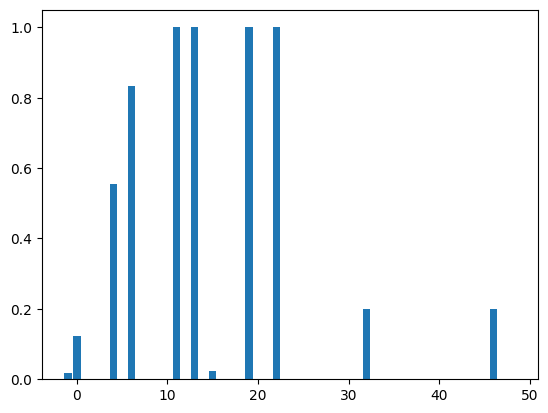

Количество элементов в каждом кластере: [ 9272 43264  3524   864    84     9    15    24   124    10    24    23
    15    11    22     5    43    54     5    19    26    19    13    10
     6     9    22     5    11     9     5     6     8     5     8    15
     6     7     5     4     5     8     5     6     4     6     3     5
     5     5]


In [190]:
df['CLUSTER_NUM'] = dbscan.labels_

df_grp = df.groupby('CLUSTER_NUM')

part_vuln_in_group = []
group_labels = []
for group in df_grp.groups.keys():
    group_labels.append(group)
    part_vuln_in_group.append(df_grp.get_group(group).VULN_BIN.mean())

plt.bar(group_labels, part_vuln_in_group)
plt.show()

cluster_ids, cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print(f"Количество элементов в каждом кластере: {cluster_sizes}")

In [191]:
len(set(dbscan.labels_))

50

### Предсказание

Разделим тестовый датасет на кластера для обучения

In [192]:
%%time
dbscan = DBSCAN(
        eps=0.95,
        min_samples=5,
        n_jobs=-1
    ).fit(x_train_tfidf)

Wall time: 1min 6s


Предсказание будем делать с помощью двух моделей:
- первая на вход получает TFIDF и в качестве разметки - номера кластеров;
- вторая на вход получает выходы первой модели и в качестве разметки - бинарная разметка.

#### MultinomialNB

In [193]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = MultinomialNB().fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = MultinomialNB().fit(positive_dbscan_labels.reshape(-1, 1), y_train)

# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10419
           1       0.00      0.00      0.00      1114

    accuracy                           0.90     11533
   macro avg       0.45      0.50      0.47     11533
weighted avg       0.82      0.90      0.86     11533

Wall time: 96.6 ms


C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

#### KNeighborsClassifier

In [194]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = KNeighborsClassifier(n_neighbors=5).fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = KNeighborsClassifier(n_neighbors=5).fit(positive_dbscan_labels.reshape(-1, 1), y_train)

# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10419
           1       1.00      0.03      0.05      1114

    accuracy                           0.91     11533
   macro avg       0.95      0.51      0.50     11533
weighted avg       0.91      0.91      0.86     11533

Wall time: 18.2 s


#### SVC

In [195]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = SVC().fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = SVC().fit(positive_dbscan_labels.reshape(-1, 1), y_train)


# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10419
           1       0.00      0.00      0.00      1114

    accuracy                           0.90     11533
   macro avg       0.45      0.50      0.47     11533
weighted avg       0.82      0.90      0.86     11533

Wall time: 5min 41s


C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

#### Деревья

Набор условий, создаваемый по максимальной информативности

In [196]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = DecisionTreeClassifier().fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = DecisionTreeClassifier().fit(positive_dbscan_labels.reshape(-1, 1), y_train)


# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10419
           1       0.93      0.02      0.04      1114

    accuracy                           0.91     11533
   macro avg       0.92      0.51      0.50     11533
weighted avg       0.91      0.91      0.86     11533

Wall time: 13 s


#### Случайный лес

Набор деревьев, исследующих разные наборы признаков

In [197]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = RandomForestClassifier(max_depth=50, max_features=0.75,
                             n_jobs=-1, random_state=0).fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = RandomForestClassifier(max_depth=50, max_features=0.75,
                               n_jobs=-1, random_state=0).fit(positive_dbscan_labels.reshape(-1, 1), y_train)

# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10419
           1       1.00      0.02      0.05      1114

    accuracy                           0.91     11533
   macro avg       0.95      0.51      0.50     11533
weighted avg       0.91      0.91      0.86     11533

Wall time: 2min 29s


#### Extremely Randomized Trees

In [198]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = ExtraTreesClassifier(bootstrap=False, max_features=0.75, min_samples_split=9,
                           n_jobs=-1, random_state=0).fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = ExtraTreesClassifier(bootstrap=False, max_features=0.75, min_samples_split=9,
                             n_jobs=-1, random_state=0).fit(positive_dbscan_labels.reshape(-1, 1), y_train)

# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10419
           1       1.00      0.02      0.05      1114

    accuracy                           0.91     11533
   macro avg       0.95      0.51      0.50     11533
weighted avg       0.91      0.91      0.86     11533

Wall time: 1min 53s


#### AdaBoost

Бустинг (поправка на неправильно классифицированных запросах)

In [199]:
%%time
# обучение
max_dbscan = max(dbscan.labels_)
positive_dbscan_labels = np.array([max_dbscan + 1 if x == -1 else x for x in dbscan.labels_])

clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(x_train_tfidf, positive_dbscan_labels)
clf_2 = AdaBoostClassifier(n_estimators=100, random_state=0).fit(positive_dbscan_labels.reshape(-1, 1), y_train)

# предсказание
y_hidden = clf.predict(x_test_tfidf)
y_pred = clf_2.predict(y_hidden.reshape(-1, 1))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10419
           1       0.00      0.00      0.00      1114

    accuracy                           0.90     11533
   macro avg       0.45      0.50      0.47     11533
weighted avg       0.82      0.90      0.86     11533

Wall time: 41.9 s


C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asinadskiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Вывод по многоклассовой классификации: она не дала прироста точности по сравнению с одноклассовой классификацией

# Выводы

Лучшим вариантом оказалось посчитать для топ-500 n-грамм каждого запроса TF-IDF и использовать эти данные для сверхслучайного леса.

Многоклассовая классификация, нейросетевой подход показали результат не лучше.

В разделе "Future work" указал бы, что можно было бы попробовать использовать другие признаки (сейчас используется только одна колонка).

Если получится - разгадать загадку странных символов, ломающих разметку в CSV, но обнаруживающихся в строках со многообещающими вхождениями "SQL Injection" и подобными. Посмотреть на EVENT_ID - глазами в нём прослеживается некий шаблон, состоящий из двух частей. Возможно, от этого поля что-то зависит.